In [32]:
%store -r cust_lead

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'count')

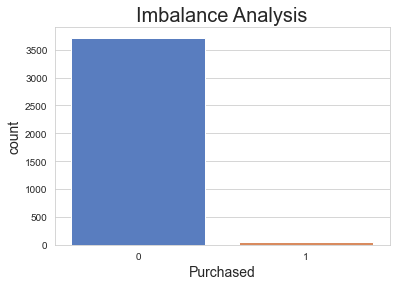

In [33]:
# Plotting the imbalance Analysis

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (6,4))
plt.title('Imbalance Analysis',  fontsize=20)
chart = sns.countplot(data=cust_lead, x='b_gekauft_gesamt', palette='muted')
plt.xlabel('Purchased', fontsize=14)
plt.ylabel('count', fontsize=14)

#### This confirms that this is an imbalanced dataset. 

### This makes feature selection a very tedious and complex process. The standard approach to deal with the problem is either downsampling the majority class or upsampling the minority class. With respect to time, I went with an approach of using Lasso Regularization as the penalty factor so it can help in variable selection much quicker

In [34]:
# Assigning target variable to y
y = cust_lead['b_gekauft_gesamt']
y.head()

# Assigning training variables to y
X=cust_lead.iloc[:, 1:23]
X.drop('q_OpeningDays', axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3772 entries, 0 to 3772
Data columns (total 21 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   b_specialisation_i                              3772 non-null   int64   
 1   b_specialisation_h                              3772 non-null   int64   
 2   b_specialisation_g                              3772 non-null   int64   
 3   b_specialisation_f                              3772 non-null   int64   
 4   b_specialisation_e                              3772 non-null   int64   
 5   b_specialisation_d                              3772 non-null   int64   
 6   b_specialisation_c                              3772 non-null   int64   
 7   b_specialisation_b                              3772 non-null   int64   
 8   b_specialisation_a                              3772 non-null   int64   
 9   b_specialisation_j            

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                                           feature           VIF
0                               b_specialisation_i      1.983506
1                               b_specialisation_h      1.818200
2                               b_specialisation_g      2.221474
3                               b_specialisation_f      1.469301
4                               b_specialisation_e      2.132665
5                               b_specialisation_d      1.127752
6                               b_specialisation_c      1.101229
7                               b_specialisation_b      1.083586
8                               b_specialisation_a      1.683966
9                               b_specialisation_j      1.720512
10                               q_OpeningDays_cat     21.131041
11                                  q_OpeningHours     17.448330
12                   q_2017 Average Household Size   1329.502617
13                         q_2017 Total Households  79511.587139
14     q_2017 HHs: 5th Qu

#### High values of VIF indicate serious concern of multicollinearity

In [36]:
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

X_filtered = calculate_vif_(X, thresh=100.0)

dropping 'q_2017 Total Households' at index: 13
dropping 'q_2017 Purchasing Power: Per Capita' at index: 15
dropping 'q_2017 Total Population' at index: 15
dropping 'q_2017 Personal Care: Per Capita' at index: 17
dropping 'q_2017 HHs: 5th Quintile (68.759 and above)' at index: 13
dropping 'q_5th Quint by Total HH' at index: 13
Remaining variables:
Index(['b_specialisation_i', 'b_specialisation_h', 'b_specialisation_g',
       'b_specialisation_f', 'b_specialisation_e', 'b_specialisation_d',
       'b_specialisation_c', 'b_specialisation_b', 'b_specialisation_a',
       'b_specialisation_j', 'q_OpeningDays_cat', 'q_OpeningHours',
       'q_2017 Average Household Size',
       'q_2017 Pop 15+/Edu: University, Fachhochschule', 'q_Uni by Total Pop'],
      dtype='object')


In [37]:
# After filtering the features based on high VIF

vif_data_after = pd.DataFrame()
vif_data_after["feature"] = X_filtered.columns
  
# calculating VIF for each feature
vif_data_after["VIF"] = [variance_inflation_factor(X_filtered.values, i)
                          for i in range(len(X_filtered.columns))]
  
print(vif_data_after)

                                           feature        VIF
0                               b_specialisation_i   1.978914
1                               b_specialisation_h   1.793029
2                               b_specialisation_g   2.195492
3                               b_specialisation_f   1.465367
4                               b_specialisation_e   2.125399
5                               b_specialisation_d   1.127309
6                               b_specialisation_c   1.100796
7                               b_specialisation_b   1.081168
8                               b_specialisation_a   1.681254
9                               b_specialisation_j   1.711968
10                               q_OpeningDays_cat  20.937667
11                                  q_OpeningHours  17.418577
12                   q_2017 Average Household Size  12.317525
13  q_2017 Pop 15+/Edu: University, Fachhochschule   5.557568
14                              q_Uni by Total Pop  18.760446


#### VIF values have much improved

In [38]:
# Splitting the data into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, train_size=0.7, test_size=0.3, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2640 entries, 1616 to 3175
Data columns (total 15 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   b_specialisation_i                              2640 non-null   int64   
 1   b_specialisation_h                              2640 non-null   int64   
 2   b_specialisation_g                              2640 non-null   int64   
 3   b_specialisation_f                              2640 non-null   int64   
 4   b_specialisation_e                              2640 non-null   int64   
 5   b_specialisation_d                              2640 non-null   int64   
 6   b_specialisation_c                              2640 non-null   int64   
 7   b_specialisation_b                              2640 non-null   int64   
 8   b_specialisation_a                              2640 non-null   int64   
 9   b_specialisation_j         

In [39]:
# Scaling numeric columns (Standardize features by removing the mean and scaling to unit variance)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols=X_train.select_dtypes(include=['float64', 'int64']).columns
X_train_scaled = X_train.copy()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])

X_train_scaled.head()

,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j,q_OpeningDays_cat,q_OpeningHours,q_2017 Average Household Size,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_Uni by Total Pop
1616,-0.535303,1.841923,1.691050,2.819424,1.568447,-0.075593,-0.058487,-0.144505,-0.398637,-0.591349,4,0.493101,-0.922349,1.389698,1.091359
2111,-0.535303,-0.542911,-0.591349,-0.354682,-0.637573,-0.075593,-0.058487,-0.144505,-0.398637,-0.591349,5,0.954769,-0.922349,-0.785202,-1.181894
3684,-0.535303,-0.542911,-0.591349,-0.354682,-0.637573,-0.075593,-0.058487,-0.144505,-0.398637,1.691050,0,-1.430516,1.052510,-0.688102,-0.769430
1163,-0.535303,-0.542911,-0.591349,-0.354682,1.568447,-0.075593,-0.058487,-0.144505,-0.398637,-0.591349,4,0.570045,-0.922349,1.568285,1.199126
942,1.868100,-0.542911,-0.591349,2.819424,1.568447,-0.075593,-0.058487,-0.144505,2.508549,-0.591349,5,-0.276346,2.369084,-0.803606,-1.059476


In [47]:
from sklearn.linear_model import LogisticRegression

lasso_log = LogisticRegression(C = 0.1, class_weight= 'balanced', penalty= 'l1', solver= 'liblinear', random_state=42)
result = lasso_log.fit(X_train_scaled, y_train)

In [48]:
import statsmodels.api as sm

logit_model=sm.Logit(y, X_filtered)
result=logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.066147
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       b_gekauft_gesamt   No. Observations:                 3772
Model:                          Logit   Df Residuals:                     3757
Method:                           MLE   Df Model:                           14
Date:                Mon, 06 Sep 2021   Pseudo R-squ.:                  0.1557
Time:                        07:02:51   Log-Likelihood:                -249.51
converged:                       True   LL-Null:                       -295.53
Covariance Type:            nonrobust   LLR p-value:                 1.558e-13
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
b_specialisation_i                                -0.8560      0.456     -1.878      0.060      -1.749       0.037
b_specialisation_h                                -0.1439      0.394     -0.365      0.715      -0.917       0.629
b_specialisation_g                                 0.5962      0.370      1.609      0.108      -0.130       1.322
b_specialisation_f                                 1.6690      0.374      4.463      0.000       0.936       2.402
b_specialisation_e                                -1.4284      0.465     -3.071      0.002      -2.340      -0.517
b_specialisation_d                                 2.6505      0.629      4.214      0.000       1.418       3.883
b_specialisation_c                                -0.9744      1.247     -0.782      0.434      -3.418       1.469
b_specialisation_b                                 0.4148      0.720      0.576      0.565      -0.996       1.826
b_specialisation_a                                 0.2603      0.436      0.597      0.551      -0.595       1.115
b_specialisation_j                                 0.9123      0.329      2.774      0.006       0.268       1.557
q_OpeningDays_cat                                 -0.0080      0.173     -0.046      0.963      -0.347       0.331
q_OpeningHours                                     0.0081      0.024      0.331      0.740      -0.040       0.056
q_2017 Average Household Size                     -2.3222      0.252     -9.206      0.000      -2.817      -1.828
q_2017 Pop 15+/Edu: University, Fachhochschule   5.49e-07   1.73e-06      0.317      0.752   -2.85e-06    3.95e-06
q_Uni by Total Pop                                 2.2292      5.610      0.397      0.691      -8.766      13.224
==================================================================================================================
"""

In [57]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lasso_log,X_train,y_train,cv=5,scoring='roc_auc',n_jobs=-1)
acc = cross_val_score(lasso_log,X_train,y_train,cv=5,scoring='accuracy',n_jobs=-1)
rand_scores = pd.DataFrame({
    'cv':range(1,6),
    'roc_auc score':scores,
    'accuracy score':acc
    })
print('AUC :',rand_scores['roc_auc score'].mean())
print('accuracy :',rand_scores['accuracy score'].mean())
rand_scores.sort_values(by='roc_auc score',ascending=False)

AUC : 0.6798641165620933
accuracy : 0.7321969696969697


,cv,roc_auc score,accuracy score
4,5,0.841148,0.710227
2,3,0.781731,0.746212
1,2,0.671635,0.753788
3,4,0.561538,0.731061
0,1,0.543269,0.719697


#### It needs further tuning to achieve better AUC